In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

Selanjutnya, kita perlu menentukan hyperparameter yang akan digunakan selama proses pelatihan model dengan catatan Anda dapat melakukan perubahan pada masing-masing variabel. 

In [2]:
latent_dim = 100
hidden_dim = 256
image_dim = 28 * 28
batch_size = 64
learning_rate = 0.0002
num_epochs = 50

Kemudian kita perlu mempersiapkan dan memuat dataset MNIST untuk pelatihan dalam bentuk yang sesuai. Transformasi diterapkan untuk memastikan data berada dalam format yang benar dan memiliki skala sesuai untuk pelatihan

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:09<00:00, 1.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 104kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 785kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.5MB/s]


Generator dan Discriminator

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, image_dim),
            nn.Tanh()
        )
 
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
 
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [6]:
generator = Generator()
discriminator = Discriminator()

In [7]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)
 
# Loss function
adversarial_loss = nn.BCELoss()

In [8]:
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)
 
        real_imgs = imgs
 
        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()
 
        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
 
    print(f'Epoch {epoch + 1}/{num_epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

Epoch 1/50, D Loss: 0.0276377871632576, G Loss: 3.6438751220703125
Epoch 2/50, D Loss: 0.2410760521888733, G Loss: 1.2229169607162476
Epoch 3/50, D Loss: 0.01670004054903984, G Loss: 3.680295467376709
Epoch 4/50, D Loss: 0.01313190907239914, G Loss: 5.076641082763672
Epoch 5/50, D Loss: 0.025556350126862526, G Loss: 4.619226932525635
Epoch 6/50, D Loss: 0.008491729386150837, G Loss: 7.780584335327148
Epoch 7/50, D Loss: 0.13375721871852875, G Loss: 6.306591510772705
Epoch 8/50, D Loss: 0.12106073647737503, G Loss: 5.112082481384277
Epoch 9/50, D Loss: 0.04803602024912834, G Loss: 6.356810569763184
Epoch 10/50, D Loss: 0.10544956475496292, G Loss: 4.758246898651123
Epoch 11/50, D Loss: 0.04494370147585869, G Loss: 4.573112487792969
Epoch 12/50, D Loss: 0.061492666602134705, G Loss: 4.18356466293335
Epoch 13/50, D Loss: 0.12849760055541992, G Loss: 2.3904531002044678
Epoch 14/50, D Loss: 0.06669168174266815, G Loss: 3.8055570125579834
Epoch 15/50, D Loss: 0.14413930475711823, G Loss: 2.5

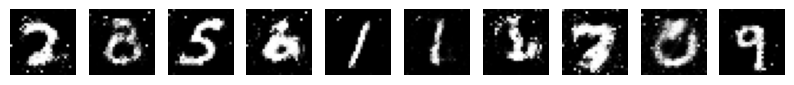

In [11]:
import matplotlib.pyplot as plt
# Generate new images
def generate_images(generator, num_images, latent_dim):
    # Menentukan status generator menjadi evaluation mode
    generator.eval()
 
    # Generate random noise
    z = torch.randn(num_images, latent_dim)
 
    # Generate images from noise
    gen_imgs = generator(z)
 
    # Rescale images menjadi rentang [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5
 
    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1))
    for i in range(num_images):
        axs[i].imshow(gen_imgs[i].detach().numpy().squeeze(), cmap='gray')
        axs[i].axis('off')
    plt.show()
 
# Generate dan menampilkan 10 gambar baru
generate_images(generator, 10, latent_dim)